# Test for CNN Model

# 0. Hyperparameters

In [35]:
class Config:
    batch_size = 64
    learning_rate = 1e-3
    num_epochs = 20
    scheduler_gamma = 0.9
    train_loader = None
    test_loader = None

In [36]:
config = Config

## 0.1. Load Processor

In [3]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-small")

# 1. Prepare Dataset

## 1.1. Load Dataset

In [4]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
from datasets import load_dataset
test_dataset = load_dataset("./prepared_dataset_test")

Resolving data files:   0%|          | 0/25 [00:00<?, ?it/s]

In [11]:
test_dataset

DatasetDict({
    test: Dataset({
        features: ['input_features', 'labels', 'class'],
        num_rows: 12102
    })
})

In [12]:
test_dataset = test_dataset['test']

In [13]:
test_dataset

Dataset({
    features: ['input_features', 'labels', 'class'],
    num_rows: 12102
})

In [14]:
test_dataset.set_format("torch")

## 1.2. Collator

In [15]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # 인풋 데이터와 라벨 데이터의 길이가 다르며, 따라서 서로 다른 패딩 방법이 적용되어야 한다. 그러므로 두 데이터를 분리해야 한다.
        # 먼저 오디오 인풋 데이터를 간단히 토치 텐서로 반환하는 작업을 수행한다.
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # Tokenize된 레이블 시퀀스를 가져온다.
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # 레이블 시퀀스에 대해 최대 길이만큼 패딩 작업을 실시한다.
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # 패딩 토큰을 -100으로 치환하여 loss 계산 과정에서 무시되도록 한다.
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # 이전 토크나이즈 과정에서 bos 토큰이 추가되었다면 bos 토큰을 잘라낸다.
        # 해당 토큰은 이후 언제든 추가할 수 있다.
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        class_list = [feature["class"] for feature in features]
        classes = torch.stack(class_list)
        classes -= 1 # torch.tensor([1, 2, 3, ..., 19])를 torch.tensor([0, 1, 2, ..., 18])로 변경

        return batch, classes

In [16]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

## 1.3. DataLoader

In [17]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(test_dataset, batch_size=Config.batch_size, collate_fn=data_collator)

In [18]:
config.test_loader = test_dataloader

# 2. Model

In [23]:
import torch
import torch.nn as nn

class MyNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=(1, 2), padding=(1, 1)), # (?, 1, 80, 3000) -> (?, 8, 80, 1500)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # (?, 8, 80, 1500) -> (?, 8, 40, 750)
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=(1, 2), padding=(1, 2)), # (?, 8, 40, 750) -> (?, 16, 40, 376)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # (?, 16, 40, 376) -> (?, 16, 20, 188)
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=(1, 2), padding=(1, 1)), # (?, 16, 20, 188) -> (?, 32, 20, 94)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # (?, 32, 20, 94) -> (?, 32, 10, 47)
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=(1, 2), padding=(1, 2)), # (?, 32, 10, 47) -> (?, 64, 10, 24)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # (?, 64, 10, 24) -> (?, 64, 5, 12)
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=(1, 2), padding=(1, 1)), # (?, 64, 5, 12) -> (?, 128, 5, 6)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))) # (?, 128, 5, 6) -> (?, 128, 5, 3)

        self.fc1 = nn.Linear(128*5*3, 128, bias=True) # (?, 256, 5, 3) -> (?, 128)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu') # He Initialization
        self.linear1 = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            nn.Dropout(p=0.2)) # 20% dropout

        self.fc2 = nn.Linear(128, 64, bias=True) # (?, 128) -> (?, 64)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        self.linear2 = nn.Sequential(
            self.fc2,
            nn.ReLU(),
            nn.Dropout(p=0.2)) # 20% dropout

        self.fc = nn.Linear(64, 19, bias=True) # (?, 64), (?, 19)

    def forward(self, x):
        x = x.view(-1, 1, 80, 3000)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 128*5*3)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.fc(x)
        return x

model = MyNet().to(device)

# 적절한 optimizer, Scheduler를 선택: torch.optim을 사용
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=1e-4) # Adam Optimizer + L2 Regularization(weight_decay)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=config.scheduler_gamma) # Exponential Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# 적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

# 3. Inference

In [24]:
from tqdm import tqdm

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    predictions_list = []
    labels_list = []
    
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc="Evaluating") as pbar:
            for features, labels in test_loader:
                input_features = features['input_features']
                input_features = input_features.to(device)
                labels = labels.to(device)
                
                output = model(input_features)
                
                test_loss += criterion(output, labels).item()
                prediction = output.max(1, keepdim = True)[1]
                correct += prediction.eq(labels.view_as(prediction)).sum().item()

                predictions_list.extend(prediction)
                labels_list.extend(labels)
                pbar.update(1)

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy, predictions_list, labels_list

def pred(model, test_loader):
    model.eval()
    pred_li = [] # 예측 결과를 모두 저장하는 리스트입니다.

    with torch.no_grad():
        with tqdm(total=len(test_loader), desc="Predicting") as pbar:
            for features, labels in test_loader:
                input_features = features['input_features']
                input_features = input_features.to(device)
                output = model(input_features)
                pred_li.append(output.cpu().numpy().argmax(axis=1))
                pbar.update(1)

    return np.concatenate(pred_li) # 예측 결과

In [25]:
def inference(model_name, check_epoch):
    check_point = model_name + "/ckpt-" + str(check_epoch) + ".pt"
    ckpt = torch.load(check_point)
    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt['optimizer'])
    print(f'Load model: {model_name} | epoch {check_epoch}')

    test_loss, test_accuracy, predictions_list, labels_list = evaluate(model, config.test_loader)
    print(f"Test Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")

    return predictions_list, labels_list

In [26]:
predictions_list, labels_list = inference('save06', 13)

Load model: save06 | epoch 13


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 190/190 [00:53<00:00,  3.54it/s]

Test Loss: 0.1900, 	Test Accuracy: 94.61 % 



In [27]:
predictions_list = [int(tensor) for tensor in predictions_list]

In [28]:
labels_list = [int(tensor) for tensor in labels_list]

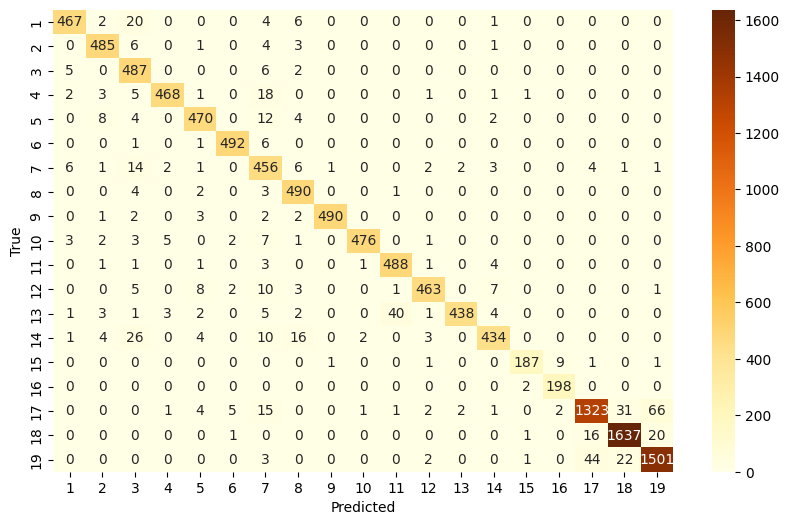

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

confusion = confusion_matrix(labels_list, predictions_list)

class_labels = [f'{i}' for i in range(1, 20)]

plt.figure(figsize=(10, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='YlOrBr', xticklabels=class_labels, yticklabels=class_labels)

# 축 레이블 추가
plt.xlabel('Predicted')
plt.ylabel('True')

# 플롯 보여주기
plt.show()

# Inference

In [47]:
import librosa

y, s = librosa.load("위급상황.wav", sr=16000)

input_features = processor(y, sampling_rate=16000, return_tensors="pt").input_features
with torch.no_grad():
    output = model(input_features.to("cuda"))
    prediction = output.max(1, keepdim = True)[1].item()
    print("prediction:", prediction)

prediction: 3


In [48]:
y, s = librosa.load("비위급상황.wav", sr=16000)

input_features = processor(y, sampling_rate=16000, return_tensors="pt").input_features
with torch.no_grad():
    output = model(input_features.to("cuda"))
    prediction = output.max(1, keepdim = True)[1].item()
    print("prediction:", prediction)

prediction: 16


In [56]:
y, s = librosa.load("낙상.wav", sr=16000)

input_features = processor(y, sampling_rate=16000, return_tensors="pt").input_features
with torch.no_grad():
    output = model(input_features.to("cuda"))
    prediction = output.max(1, keepdim = True)[1].item()
    print("prediction:", prediction)

prediction: 13


In [66]:
y, s = librosa.load("실내.wav", sr=16000)

input_features = processor(y, sampling_rate=16000, return_tensors="pt").input_features
with torch.no_grad():
    output = model(input_features.to("cuda"))
    prediction = output.max(1, keepdim = True)[1].item()
    print("prediction:", prediction)

prediction: 14


In [63]:
y, s = librosa.load("지연 위급상황.wav", sr=16000)

input_features = processor(y, sampling_rate=16000, return_tensors="pt").input_features
with torch.no_grad():
    output = model(input_features.to("cuda"))
    prediction = output.max(1, keepdim = True)[1].item()
    print("prediction:", prediction)

prediction: 4


In [67]:
A = [label < 14 for label in labels_list]
B = [pred < 14 for pred in predictions_list]

In [68]:
acc = 0
for a, b in zip(A, B):
    if a == b:
        acc += 1 / len(A)
print(acc)

0.996033713435518


In [69]:
import json

with open('pred_CNN.json', 'w') as file:
    json.dump(B, file)